<a href="https://colab.research.google.com/github/Mantis-Ryuji/Playground/blob/main/01_Multi_task_ConvAE_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## オートエンコーダがクラスラベルを同時に学習する場合、潜在空間はどんなものになる？

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import random
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(42)

### MNIST 手書き数字で試してみる

In [3]:
BATCH_SIZE = 128
mnist_data = MNIST("./data",
                   train=True,
                   download=True,
                   transform=transforms.ToTensor())

test_data = datasets.MNIST("./data",
                           train=False,
                           download=True,
                           transform=transforms.ToTensor())

train_size = int(len(mnist_data) * 0.8)
val_size = int(len(mnist_data) * 0.2)

train_data, val_data = torch.utils.data.random_split(mnist_data, [train_size, val_size])

train_loader = DataLoader(dataset=train_data,
                          batch_size=BATCH_SIZE,
                          shuffle=True)

val_loader = DataLoader(dataset=val_data,
                        batch_size=BATCH_SIZE,
                        shuffle=True)

test_loader = DataLoader(dataset=test_data,
                          batch_size=BATCH_SIZE,
                          shuffle=False)

type <class 'list'> len 2
x_batch[0].shape: torch.Size([128, 1, 28, 28])
x_batch[1].shape: torch.Size([128])


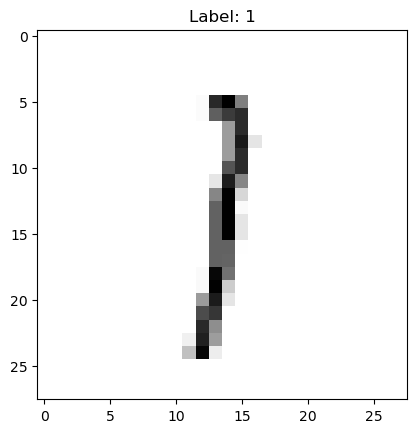

In [4]:
# 1回分のバッチを取り出してデータとラベルの形状を確認
for x_batch in train_loader:
    print('type', type(x_batch), 'len', len(x_batch))
    print("x_batch[0].shape:", x_batch[0].shape)
    print("x_batch[1].shape:", x_batch[1].shape)
    plt.imshow(x_batch[0][100].squeeze(0), cmap='binary')
    plt.title(f'Label: {x_batch[1][100]}')
    break

### ResNet風のEncoder
多分過剰だと思うが層を重ねてみたかった。こういうオートエンコーダの場合、`maxpool`と`batchnorm`って入れていいのか分からない。再構成に影響しそうと思って今回は外している。

In [5]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()
        self.stride = stride
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=1)

        self.shortcut = nn.Identity()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride)

    def forward(self, x):
        residual = self.shortcut(x)
        out = self.conv1(x)
        out = self.relu(out)
        out = self.conv2(out)
        out += residual
        out = self.relu(out)
        return out

In [6]:
class ResNet_Encoder(nn.Module):
    def __init__(self, in_channels=1, z_dim=10):
        super().__init__()
        self.layer1 = ResidualBlock(in_channels, 16, stride=2)
        self.layer2 = ResidualBlock(16, 32, stride=2)
        self.layer3 = ResidualBlock(32, 64, stride=2)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, z_dim)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        z = self.fc2(x)
        return z

### 再構成と分類
ここでは画像を再構成するシンプルな構造のDecoderと潜在空間から数字を分類するシンプルなClassifierを定義している

In [7]:
class Simple_Decoder(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        self.fc1 = nn.Linear(z_dim, 128)
        self.fc2 = nn.Linear(128, 64 * 4 * 4)
        self.deconv1 = nn.ConvTranspose2d(64, 32, 5, 2, 2, output_padding=0)
        self.deconv2 = nn.ConvTranspose2d(32, 16, 5, 2, 2, output_padding=1)
        self.deconv3 = nn.ConvTranspose2d(16, 1, 5, 2, 2, output_padding=1)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, z):
        x = self.relu(self.fc1(z))
        x = self.relu(self.fc2(x))
        x = x.view(-1, 64, 4, 4)
        x = self.relu(self.deconv1(x))
        x = self.relu(self.deconv2(x))
        x = self.sigmoid(self.deconv3(x))
        return x

In [8]:
class Simple_Classifier(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        self.fc1 = nn.Linear(z_dim, z_dim)
        self.bn1 = nn.BatchNorm1d(z_dim)
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(z_dim, 10)

        self.relu = nn.ReLU()

    def forward(self, z):
        x = self.fc1(z)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

### マルチタスク畳み込みオートエンコーダ
損失関数に関しては`Uncertainty Weighted Loss`を採用<br>
https://openaccess.thecvf.com/content_cvpr_2018/papers/Kendall_Multi-Task_Learning_Using_CVPR_2018_paper.pdf
<br>これ凄い

In [9]:
class Multitask_CAE(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        self.encoder = ResNet_Encoder(in_channels=1, z_dim=z_dim)
        self.decoder = Simple_Decoder(z_dim)
        self.classifier = Simple_Classifier(z_dim)

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        logits = self.classifier(z)
        return z, x_recon, logits

In [10]:
class LossFunction(nn.Module):
    def __init__(self):
        super().__init__()

        self.log_sigma_bce = nn.Parameter(torch.tensor(0.0))
        self.log_sigma_etrpy = nn.Parameter(torch.tensor(0.0))

        self.bce = nn.BCELoss(reduction='sum')
        self.etrpy = nn.CrossEntropyLoss(reduction='sum')

    def forward(self, x, label, x_recon, logits):
        batch_size = x.size(0)

        BCE = self.bce(x_recon, x)
        Etrpy = self.etrpy(logits, label)

        weighted_loss = (
            0.5 * torch.exp(-self.log_sigma_bce) * BCE + 0.5 * self.log_sigma_bce * batch_size +
            0.5 * torch.exp(-self.log_sigma_etrpy) * Etrpy + 0.5 * self.log_sigma_etrpy * batch_size
        )

        return weighted_loss / batch_size, BCE / batch_size, Etrpy / batch_size

### 10次元に埋め込む

In [11]:
def train(z_dim, num_epochs, train_loader, val_loader):

    model = Multitask_CAE(z_dim).to('cuda')
    criterion = LossFunction().to('cuda')
    optimizer = torch.optim.Adam(list(model.parameters()) + list(criterion.parameters()), lr=0.001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1)
    

    train_history = []
    val_history = []
    best_val_loss = float('inf')
    best_model_state = None

    for epoch in range(num_epochs):
        model.train()
        train_loss, train_bce, train_etrpy, total_train_samples = 0, 0, 0, 0

        for x, label in train_loader:
            x = x.to('cuda')
            label = label.to('cuda')

            optimizer.zero_grad()
            z, x_recon, logits = model(x)
            loss, bce, etrpy = criterion(x, label, x_recon, logits)

            loss.backward()
            optimizer.step()

            train_loss += loss.item() * x.size(0)
            train_bce += bce.item() * x.size(0)
            train_etrpy += etrpy.item() * x.size(0)
            total_train_samples += x.size(0)

        train_loss /= total_train_samples
        train_bce /= total_train_samples
        train_etrpy /= total_train_samples
        train_history.append((train_loss, train_bce, train_etrpy))

        print(f"[{epoch:02d}] Train Loss: {train_loss:.5f} | Train BCE: {train_bce:.5f} | Train Etrpy: {train_etrpy:.5f}")


        model.eval()
        with torch.no_grad():
            val_loss, val_bce, val_etrpy, total_val_samples = 0, 0, 0, 0

            for x, label in val_loader:
                x = x.to('cuda')
                label = label.to('cuda')

                z, x_recon, logits = model(x)
                loss, bce, etrpy = criterion(x, label, x_recon, logits)

                val_loss += loss.item() * x.size(0)
                val_bce += bce.item() * x.size(0)
                val_etrpy += etrpy.item() * x.size(0)
                total_val_samples += x.size(0)

            val_loss /= total_val_samples
            val_bce /= total_val_samples
            val_etrpy /= total_val_samples
            val_history.append((val_loss, val_bce, val_etrpy))

            scheduler.step(val_loss)

            print(f"[{epoch:02d}] Valid Loss: {val_loss:.5f} | Valid BCE: {val_bce:.5f} | Valid Etrpy: {val_etrpy:.5f}")

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_state = model.state_dict()

    torch.save(best_model_state, f"Multitask_CAE.pth")
    print(f"Best model saved with validation loss: {best_val_loss:.5f}")

    best_model = Multitask_CAE(z_dim).to('cuda')
    best_model.load_state_dict(best_model_state)

    return best_model, train_history, val_history

In [12]:
best_model, train_history, val_history = train(10, 30, train_loader, val_loader)

[00] Train Loss: 83.99153 | Train BCE: 184.79391 | Train Etrpy: 1.76889
[00] Valid Loss: 47.89700 | Valid BCE: 120.46997 | Valid Etrpy: 1.29014
[01] Train Loss: 39.74122 | Train BCE: 109.55115 | Train Etrpy: 1.13085
[01] Valid Loss: 32.96539 | Valid BCE: 100.58645 | Valid Etrpy: 0.77516
[02] Train Loss: 28.49774 | Train BCE: 94.55187 | Train Etrpy: 0.86183
[02] Valid Loss: 24.85039 | Valid BCE: 90.68172 | Valid Etrpy: 0.56540
[03] Train Loss: 22.46405 | Train BCE: 88.67271 | Train Etrpy: 0.73694
[03] Valid Loss: 20.20413 | Valid BCE: 87.58153 | Valid Etrpy: 0.46352
[04] Train Loss: 18.41531 | Train BCE: 85.87065 | Train Etrpy: 0.66273
[04] Valid Loss: 16.67124 | Valid BCE: 85.38542 | Valid Etrpy: 0.38552
[05] Train Loss: 15.34730 | Train BCE: 84.10769 | Train Etrpy: 0.58622
[05] Valid Loss: 13.93747 | Valid BCE: 83.90010 | Valid Etrpy: 0.33019
[06] Train Loss: 12.93294 | Train BCE: 82.76244 | Train Etrpy: 0.53123
[06] Valid Loss: 11.78189 | Valid BCE: 82.86559 | Valid Etrpy: 0.28793
[0

### Training History

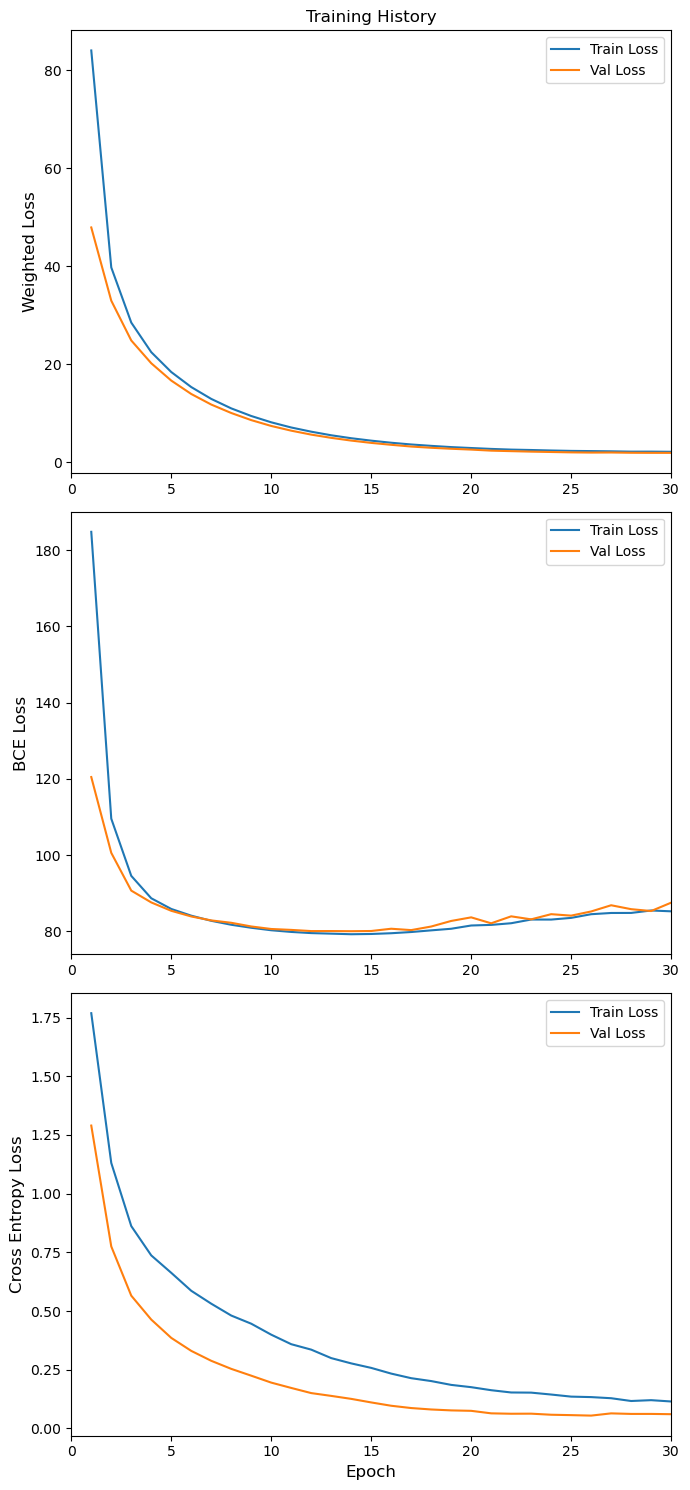

In [13]:
def plot_history(train_history, val_history, num_epoch):

    train_history = np.array(train_history)
    val_history = np.array(val_history)

    fig, ax = plt.subplots(3, 1, figsize=(7, 15))
    name = ['Weighted', 'BCE', 'Cross Entropy']
    for i in range(3):
        ax[i].plot(np.arange(num_epoch)+1, train_history[:, i], label='Train Loss')
        ax[i].plot(np.arange(num_epoch)+1, val_history[:, i], label='Val Loss')
        ax[2].set_xlabel('Epoch', fontsize=12)
        ax[i].set_ylabel(f'{name[i]} Loss', fontsize=12)
        ax[0].set_title('Training History', fontsize=12)
        ax[i].set_xlim(1, num_epoch)
        ax[i].set_xticks(np.arange(0, num_epoch+1, 5))
        ax[i].legend(loc='upper right')
    plt.tight_layout()
plot_history(train_history, val_history, 30);

### テストデータにおける潜在空間と予測ラベルの取得

In [14]:
best_model.eval()

latent_spaces = []
predict_labels = []
true_labels = []

with torch.no_grad():
    for x, label in test_loader:
        x = x.to('cuda')
        label = label.to('cuda')

        z, x_recon, logits = best_model(x)

        pred = torch.argmax(logits, dim=1)
        predict_labels.append(pred.cpu().numpy())
        true_labels.append(label.cpu().numpy())
        latent_spaces.append(z.cpu().numpy())


latent_spaces = np.concatenate(latent_spaces, axis=0)
true_labels = np.concatenate(true_labels, axis=0)
predict_labels = np.concatenate(predict_labels, axis=0)

### 分類精度の確認

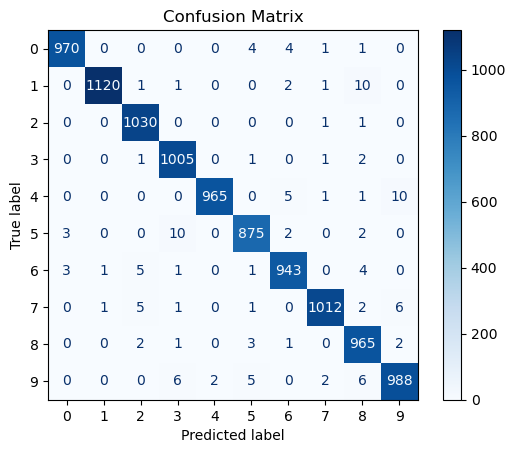

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(true_labels, predict_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix");

In [16]:
from sklearn.metrics import classification_report
report = classification_report(true_labels, predict_labels, digits=4)
print(report)

              precision    recall  f1-score   support

           0     0.9939    0.9898    0.9918       980
           1     0.9982    0.9868    0.9925      1135
           2     0.9866    0.9981    0.9923      1032
           3     0.9805    0.9950    0.9877      1010
           4     0.9979    0.9827    0.9903       982
           5     0.9831    0.9809    0.9820       892
           6     0.9854    0.9843    0.9849       958
           7     0.9931    0.9844    0.9888      1028
           8     0.9708    0.9908    0.9807       974
           9     0.9821    0.9792    0.9806      1009

    accuracy                         0.9873     10000
   macro avg     0.9872    0.9872    0.9872     10000
weighted avg     0.9874    0.9873    0.9873     10000



### 潜在空間をUMAPで2次元に削減し可視化

In [17]:
import seaborn as sns
import umap

reducer = umap.UMAP(n_components=2, random_state=42)
z_umap = reducer.fit_transform(latent_spaces)

c:\Users\PC_User\anaconda3\envs\new_gpu_env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\PC_User\anaconda3\envs\new_gpu_env\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


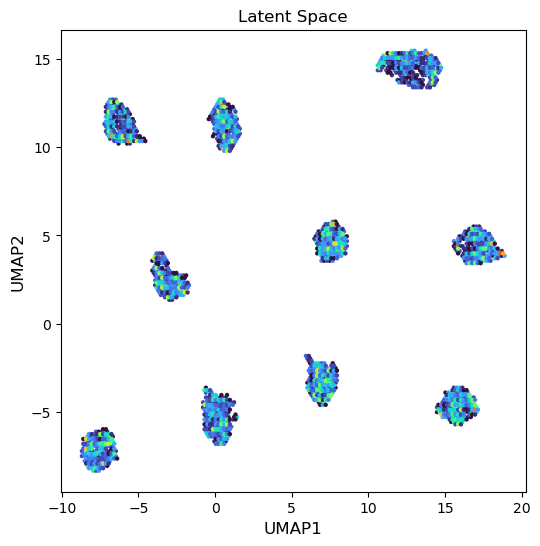

In [18]:
plt.figure(figsize=(6, 6))
plt.hexbin(x=z_umap[:, 0], y=z_umap[:, 1], gridsize=150, cmap="turbo", mincnt=1)
plt.title("Latent Space", fontsize=12)
plt.xlabel("UMAP1", fontsize=12)
plt.ylabel("UMAP2", fontsize=12);

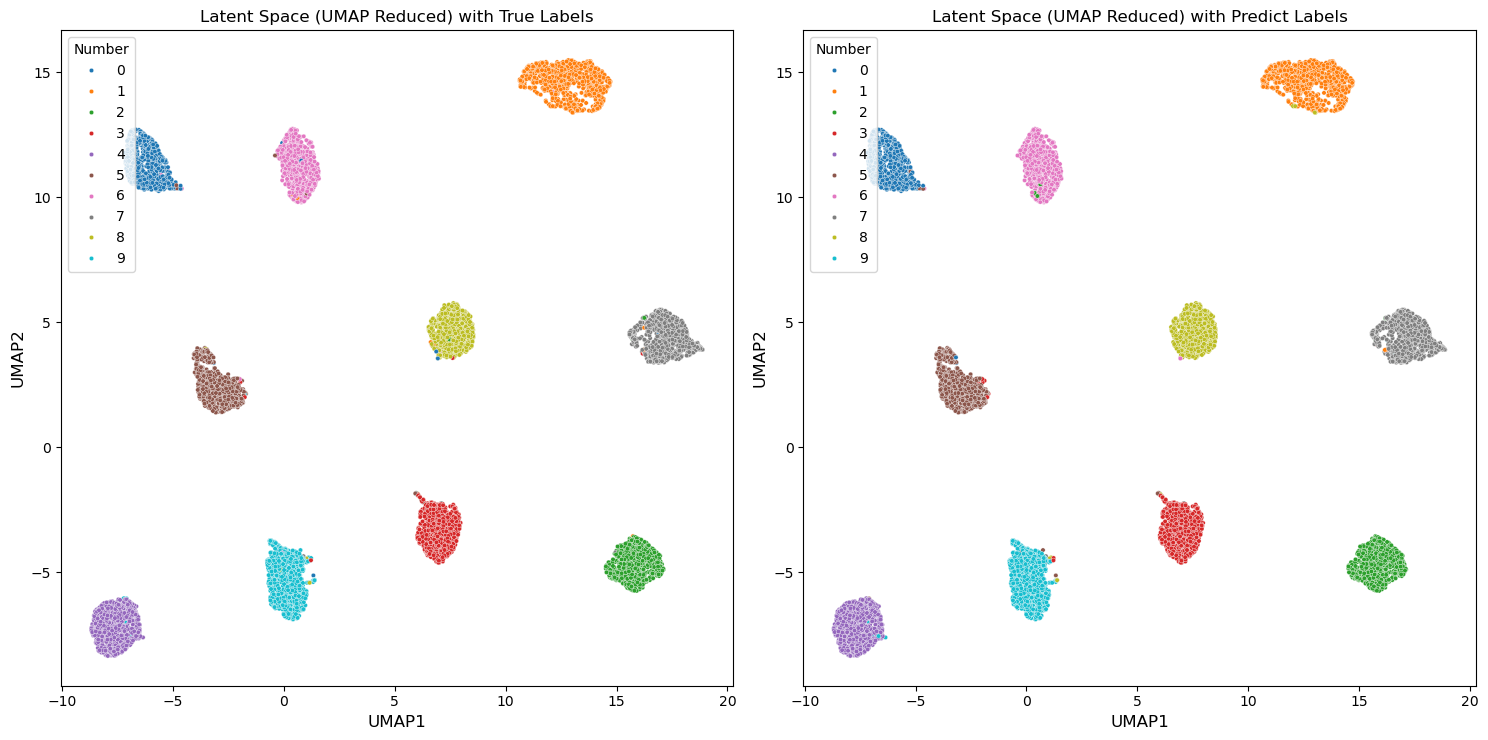

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7.5))
hue_list = [true_labels, predict_labels]
name = ['True Labels', 'Predict Labels']
for i in range(2):
    scatter = sns.scatterplot(x=z_umap[:, 0], y=z_umap[:, 1], hue=hue_list[i], palette='tab10', s=10, legend='full', ax=ax[i])
    ax[i].set_title(f"Latent Space (UMAP Reduced) with {name[i]}", fontsize=12)
    ax[i].set_xlabel("UMAP1", fontsize=12)
    ax[i].set_ylabel("UMAP2", fontsize=12)
    ax[i].legend(title="Number", loc='upper left')
plt.tight_layout();

### Note
混ざりがちな 3, 5, 8 や、4, 7, 9 でもクラスタが分かれてくれている。<br>
この `Multitask_CAE` モデルは、画像の再構築と分類を同時に行ったため、潜在空間（`z`）に、再構築タスクと分類タスクの両方をサポートする情報を埋め込むことに成功した。

### まとめ
今回はMNIST手書き数字で行ったが、潜在空間において何かクラスタリングする際、マルチタスク化すると潜在空間の分布を操作できることが分かった。<br>
教師なしで分類したいデータがあり、潜在空間に埋め込んでGMM等でクラスタリングしたいとき、何か補完したい情報をマルチタスク学習により潜在空間に反映することができると考えられる。例えば教師なしの画像分類において`Original Image`だけでなく、`Depth map`を同時に再構成させることで、より注目したい物体に注目してくれるかもしれない。<br>
それによって潜在空間がよりクラスタリングに適したものになる可能性がある。（今回数字ラベルを用いたのはご愛嬌）<br>
VAEに拡張しても面白いかもしれないが、面倒くさい。気になったらいつかやってみる。